# Using Kqlmagic to analyze Azure SQL logs and metrics

There are two main tables in Azure Log Analytics (Azure Monitor Logs) workspace that capture Azure SQL events:
1. AzureDiagnostics
2. AzureMetric


## 1. Connect to Log Analytics workspace

Workspace is similar to what a database is to SQL. You connect to Log Analytics workspace to start querying data. 

### 1.1 Load Kqlmagic
Need to load Kqlmagic first before we can start writing queries.


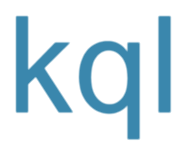

In [1]:
%reload_ext Kqlmagic

### 1.2 Connect to the desired Log Analytics workspace

In [ ]:
tenantID = input("Enter Log Analytics Workspace ID (guid)")
print(tenantID)

In [3]:
%kql loganalytics://code;workspace=tenantID;alias="myLogAnalyticsWorkspace" -try-azcli_login //-!se

## 2. Analyze events by Diagnostic Settings

Let's do a simple query first to analyze the number of events by Operation Name. 

> **Note**: Each row in AzureDiagnostic represents an event for specific Operation or category. Some SQL actions may result in generating multiple events of different types.



In [19]:
%%kql AzureDiagnostics
| summarize count() by OperationName

,OperationName,count_
0,AuditEvent,3404
1,DeadlockEvent,5
2,ErrorEvent,139
3,QueryStoreRuntimeStatisticsEvent,7
4,TimeoutEvent,1


[{'OperationName': 'AuditEvent', 'count_': 3404},
 {'OperationName': 'DeadlockEvent', 'count_': 5},
 {'OperationName': 'ErrorEvent', 'count_': 139},
 {'OperationName': 'QueryStoreRuntimeStatisticsEvent', 'count_': 7},
 {'OperationName': 'TimeoutEvent', 'count_': 1}]


The above query's equivalent in SQL is:
```
SELECT COUNT(*) AS [count_]
FROM AzureDiagnostics
GROUP BY OperationName
```


Count my Azure SQL DB events by category / diagnostic settings.

In [9]:
%%kql AzureDiagnostics
| where LogicalServerName_s == "jukoesmasqldb"
| where TimeGenerated >= ago(5d)
| summarize count() by Category
| render barchart with (title = "Azure SQL DB Diagnostic Category")

[{'Category': 'Errors', 'count_': 56},
 {'Category': 'QueryStoreRuntimeStatistics', 'count_': 6},
 {'Category': 'SQLSecurityAuditEvents', 'count_': 1539},
 {'Category': 'Deadlocks', 'count_': 4},
 {'Category': 'Timeouts', 'count_': 1}]

## 3. Performance troubleshooting Query (from Azure Portal)

Potentially a query or deadlock on the system that could lead to poor performance. The following is a query suggested by Azure Portal.

In [20]:
%%kql 
AzureMetrics
| where ResourceProvider == "MICROSOFT.SQL"
| where TimeGenerated >=ago(60min)
| where MetricName in ('deadlock')
| parse _ResourceId with * "/microsoft.sql/servers/" Resource // subtract Resource name for _ResourceId
| summarize Deadlock_max_60Mins = max(Maximum) by Resource, MetricName

,Resource,MetricName,Deadlock_max_60Mins
0,jukoesmasqldb/databases/adventureworks,deadlock,1.0


[{'Resource': 'jukoesmasqldb/databases/adventureworks', 'MetricName': 'deadlock', 'Deadlock_max_60Mins': 1}]

# AzureMetrics

This is a sample query to dig into AzureMetrics

In [21]:
%%kql
AzureMetrics
| project-away TenantId, ResourceId, SubscriptionId, _ResourceId, ResourceGroup // Don't show sensitive columns :) 
| project TimeGenerated, MetricName, Total, Count, UnitName
| take 10


,TimeGenerated,MetricName,Total,Count,UnitName
0,2021-02-03 04:39:00+00:00,storage,58458112.0,2.0,Bytes
1,2021-02-03 04:39:00+00:00,physical_data_read_percent,0.0,4.0,Percent
2,2021-02-03 04:39:00+00:00,storage_percent,0.0,2.0,Percent
3,2021-02-03 04:39:00+00:00,sessions_percent,0.0,4.0,Percent
4,2021-02-03 04:39:00+00:00,cpu_percent,0.0,4.0,Percent
5,2021-02-03 04:39:00+00:00,allocated_data_storage,67108864.0,2.0,Bytes
6,2021-02-03 04:39:00+00:00,workers_percent,0.0,4.0,Percent
7,2021-02-03 04:39:00+00:00,log_write_percent,0.0,4.0,Percent
8,2021-02-03 04:39:00+00:00,cpu_limit,12.0,6.0,Count
9,2021-02-03 04:39:00+00:00,xtp_storage_percent,0.0,4.0,Percent


[{'TimeGenerated': datetime.datetime(2021, 2, 3, 4, 39, tzinfo=tzutc()), 'MetricName': 'storage', 'Total': 58458112, 'Count': 2, 'UnitName': 'Bytes'},
 {'TimeGenerated': datetime.datetime(2021, 2, 3, 4, 39, tzinfo=tzutc()), 'MetricName': 'physical_data_read_percent', 'Total': 0, 'Count': 4, 'UnitName': 'Percent'},
 {'TimeGenerated': datetime.datetime(2021, 2, 3, 4, 39, tzinfo=tzutc()), 'MetricName': 'storage_percent', 'Total': 0, 'Count': 2, 'UnitName': 'Percent'},
 {'TimeGenerated': datetime.datetime(2021, 2, 3, 4, 39, tzinfo=tzutc()), 'MetricName': 'sessions_percent', 'Total': 0, 'Count': 4, 'UnitName': 'Percent'},
 {'TimeGenerated': datetime.datetime(2021, 2, 3, 4, 39, tzinfo=tzutc()), 'MetricName': 'cpu_percent', 'Total': 0, 'Count': 4, 'UnitName': 'Percent'},
 {'TimeGenerated': datetime.datetime(2021, 2, 3, 4, 39, tzinfo=tzutc()), 'MetricName': 'allocated_data_storage', 'Total': 67108864, 'Count': 2, 'UnitName': 'Bytes'},
 {'TimeGenerated': datetime.datetime(2021, 2, 3, 4, 39, tzinfo=tzutc()), 'MetricName': 'workers_percent', 'Total': 0, 'Count': 4, 'UnitName': 'Percent'},
 {'TimeGenerated': datetime.datetime(2021, 2, 3, 4, 39, tzinfo=tzutc()), 'MetricName': 'log_write_percent', 'Total': 0, 'Count': 4, 'UnitName': 'Percent'},
 {'TimeGenerated': datetime.datetime(2021, 2, 3, 4, 39, tzinfo=tzutc()), 'MetricName': 'cpu_limit', 'Total': 12, 'Count': 6, 'UnitName': 'Count'},
 {'TimeGenerated': datetime.datetime(2021, 2, 3, 4, 39, tzinfo=tzutc()), 'MetricName': 'xtp_storage_percent', 'Total': 0, 'Count': 4, 'UnitName': 'Percent'}]

# AzureDiagnostics

This is a sample query to dig into AzureDiagnostics. This table tends to have more details than AzureMetrics.

In [22]:
%%kql
AzureDiagnostics
| project-away TenantId, ResourceId, SubscriptionId, ResourceGroup, _ResourceId // Don't show sensitive columns :) 
| take 10

,TimeGenerated,Category,ResourceProvider,Resource,ResourceType,OperationName,ResultType,CorrelationId,ResultDescription,Tenant_g,JobId_g,RunbookName_s,StreamType_s,Caller_s,requestUri_s,Level,DurationMs,CallerIPAddress,OperationVersion,ResultSignature,id_s,status_s,LogicalServerName_s,Message,clientInfo_s,httpStatusCode_d,identity_claim_appid_g,identity_claim_http_schemas_microsoft_com_identity_claims_objectidentifier_g,userAgent_s,ruleName_s,identity_claim_http_schemas_xmlsoap_org_ws_2005_05_identity_claims_upn_s,systemId_g,isAccessPolicyMatch_b,EventName_s,httpMethod_s,subnetId_s,type_s,instanceId_s,macAddress_s,vnetResourceGuid_g,direction_s,subnetPrefix_s,primaryIPv4Address_s,conditions_sourcePortRange_s,priority_d,conditions_destinationPortRange_s,conditions_destinationIP_s,conditions_None_s,conditions_sourceIP_s,httpVersion_s,matchedConnections_d,startTime_t,endTime_t,DatabaseName_s,clientIP_s,host_s,requestQuery_s,sslEnabled_s,clientPort_d,httpStatus_d,receivedBytes_d,sentBytes_d,timeTaken_d,resultDescription_ErrorJobs_s,resultDescription_ChildJobs_s,identity_claim_http_schemas_microsoft_com_identity_claims_scope_s,workflowId_s,resource_location_s,resource_workflowId_g,resource_resourceGroupName_s,resource_subscriptionId_g,resource_runId_s,resource_workflowName_s,_schema_s,correlation_clientTrackingId_s,properties_sku_Family_s,properties_sku_Name_s,properties_tenantId_g,properties_enabledForDeployment_b,code_s,resultDescription_Summary_MachineId_s,resultDescription_Summary_ScheduleName_s,resultDescription_Summary_Status_s,resultDescription_Summary_StatusDescription_s,resultDescription_Summary_MachineName_s,resultDescription_Summary_TotalUpdatesInstalled_d,resultDescription_Summary_RebootRequired_b,resultDescription_Summary_TotalUpdatesFailed_d,resultDescription_Summary_InstallPercentage_d,resultDescription_Summary_StartDateTimeUtc_t,resource_triggerName_s,resultDescription_Summary_InitialRequiredUpdatesCount_d,properties_enabledForTemplateDeployment_b,resultDescription_Summary_EndDateTimeUtc_s,resultDescription_Summary_DurationInMinutes_s,resource_originRunId_s,properties_enabledForDiskEncryption_b,resource_actionName_s,correlation_actionTrackingId_g,resultDescription_Summary_EndDateTimeUtc_t,resultDescription_Summary_DurationInMinutes_d,conditions_protocols_s,identity_claim_ipaddr_s,ElasticPoolName_s,identity_claim_http_schemas_microsoft_com_claims_authnmethodsreferences_s,RunOn_s,query_hash_s,SourceSystem,MG,ManagementGroupName,Computer,RawData,interval_start_time_d,interval_end_time_d,logical_io_writes_d,max_logical_io_writes_d,physical_io_reads_d,max_physical_io_reads_d,logical_io_reads_d,max_logical_io_reads_d,execution_type_d,count_executions_d,cpu_time_d,max_cpu_time_d,dop_d,max_dop_d,rowcount_d,max_rowcount_d,query_max_used_memory_d,max_query_max_used_memory_d,duration_d,max_duration_d,num_physical_io_reads_d,max_num_physical_io_reads_d,log_bytes_used_d,max_log_bytes_used_d,query_id_d,plan_id_d,statement_sql_handle_s,error_state_d,deadlock_xml_s,query_plan_hash_s,error_number_d,Severity,user_defined_b,state_d,package_s,event_s,sessionName_s,originalEventTimestamp_t,audit_schema_version_d,event_time_t,sequence_number_d,action_id_s,action_name_s,succeeded_s,is_column_permission_s,session_id_d,server_principal_id_d,database_principal_id_d,target_server_principal_id_d,target_database_principal_id_d,object_id_d,user_defined_event_id_d,transaction_id_d,class_type_s,class_type_description_s,securable_class_type_s,duration_milliseconds_d,response_rows_d,affected_rows_d,client_ip_s,permission_bitmask_g,sequence_group_id_g,session_server_principal_name_s,server_principal_name_s,server_principal_sid_s,database_principal_name_s,target_server_principal_name_s,target_server_principal_sid_s,target_database_principal_name_s,server_instance_name_s,database_name_s,schema_name_s,object_name_s,statement_s,additional_information_s,user_defined_information_s,application_name_s,connection_id_g,data_sensitivity_information_s,host_name_

[{'TimeGenerated': datetime.datetime(2021, 2, 3, 4, 22, 13, 290000, tzinfo=tzutc()), 'Category': 'SQLSecurityAuditEvents', 'ResourceProvider': 'MICROSOFT.SQL', 'Resource': 'MASTER', 'ResourceType': 'SERVERS/DATABASES', 'OperationName': 'AuditEvent', 'ResultType': '', 'CorrelationId': '', 'ResultDescription': '', 'Tenant_g': '', 'JobId_g': '', 'RunbookName_s': '', 'StreamType_s': '', 'Caller_s': '', 'requestUri_s': '', 'Level': '', 'DurationMs': None, 'CallerIPAddress': '', 'OperationVersion': '', 'ResultSignature': '', 'id_s': '', 'status_s': '', 'LogicalServerName_s': 'jukoesmasqldb', 'Message': '', 'clientInfo_s': '', 'httpStatusCode_d': None, 'identity_claim_appid_g': '', 'identity_claim_http_schemas_microsoft_com_identity_claims_objectidentifier_g': '', 'userAgent_s': '', 'ruleName_s': '', 'identity_claim_http_schemas_xmlsoap_org_ws_2005_05_identity_claims_upn_s': '', 'systemId_g': '', 'isAccessPolicyMatch_b': None, 'EventName_s': '', 'httpMethod_s': '', 'subnetId_s': '', 'type_s': '', 'instanceId_s': '', 'macAddress_s': '', 'vnetResourceGuid_g': '', 'direction_s': '', 'subnetPrefix_s': '', 'primaryIPv4Address_s': '', 'conditions_sourcePortRange_s': '', 'priority_d': None, 'conditions_destinationPortRange_s': '', 'conditions_destinationIP_s': '', 'conditions_None_s': '', 'conditions_sourceIP_s': '', 'httpVersion_s': '', 'matchedConnections_d': None, 'startTime_t': None, 'endTime_t': None, 'DatabaseName_s': '', 'clientIP_s': '', 'host_s': '', 'requestQuery_s': '', 'sslEnabled_s': '', 'clientPort_d': None, 'httpStatus_d': None, 'receivedBytes_d': None, 'sentBytes_d': None, 'timeTaken_d': None, 'resultDescription_ErrorJobs_s': '', 'resultDescription_ChildJobs_s': '', 'identity_claim_http_schemas_microsoft_com_identity_claims_scope_s': '', 'workflowId_s': '', 'resource_location_s': '', 'resource_workflowId_g': '', 'resource_resourceGroupName_s': '', 'resource_subscriptionId_g': '', 'resource_runId_s': '', 'resource_workflowName_s': '', '_schema_s': '', 'correlation_clientTrackingId_s': '', 'properties_sku_Family_s': '', 'properties_sku_Name_s': '', 'properties_tenantId_g': '', 'properties_enabledForDeployment_b': None, 'code_s': '', 'resultDescription_Summary_MachineId_s': '', 'resultDescription_Summary_ScheduleName_s': '', 'resultDescription_Summary_Status_s': '', 'resultDescription_Summary_StatusDescription_s': '', 'resultDescription_Summary_MachineName_s': '', 'resultDescription_Summary_TotalUpdatesInstalled_d': None, 'resultDescription_Summary_RebootRequired_b': None, 'resultDescription_Summary_TotalUpdatesFailed_d': None, 'resultDescription_Summary_InstallPercentage_d': None, 'resultDescription_Summary_StartDateTimeUtc_t': None, 'resource_triggerName_s': '', 'resultDescription_Summary_InitialRequiredUpdatesCount_d': None, 'properties_enabledForTemplateDeployment_b': None, 'resultDescription_Summary_EndDateTimeUtc_s': '', 'resultDescription_Summary_DurationInMinutes_s': '', 'resource_originRunId_s': '', 'properties_enabledForDiskEncryption_b': None, 'resource_actionName_s': '', 'correlation_actionTrackingId_g': '', 'resultDescription_Summary_EndDateTimeUtc_t': None, 'resultDescription_Summary_DurationInMinutes_d': None, 'conditions_protocols_s': '', 'identity_claim_ipaddr_s': '', 'ElasticPoolName_s': '', 'identity_claim_http_schemas_microsoft_com_claims_authnmethodsreferences_s': '', 'RunOn_s': '', 'query_hash_s': '', 'SourceSystem': 'Azure', 'MG': '', 'ManagementGroupName': '', 'Computer': '', 'RawData': '', 'interval_start_time_d': None, 'interval_end_time_d': None, 'logical_io_writes_d': None, 'max_logical_io_writes_d': None, 'physical_io_reads_d': None, 'max_physical_io_reads_d': None, 'logical_io_reads_d': None, 'max_logical_io_reads_d': None, 'execution_type_d': None, 'count_executions_d': None, 'cpu_time_d': None, 'max_cpu_time_d': None, 'dop_d': None, 'max_dop_d': None, 'rowcount_d': None, 'max_rowcount_d': None, 'query_max_used_memory_d': None, 'max_query_max_used_memory_d': None, 'duration_d': None, 'max_duration

## Analyze (non-audit) Events

In [23]:
%%kql 
AzureDiagnostics
| summarize event_count=count() by bin(TimeGenerated, 10m), OperationName
| where OperationName <> "AuditEvent"
| render timechart 

[{'TimeGenerated': datetime.datetime(2021, 2, 3, 4, 20, tzinfo=tzutc()), 'OperationName': 'ErrorEvent', 'event_count': 13},
 {'TimeGenerated': datetime.datetime(2021, 2, 3, 4, 20, tzinfo=tzutc()), 'OperationName': 'QueryStoreRuntimeStatisticsEvent', 'event_count': 3},
 {'TimeGenerated': datetime.datetime(2021, 2, 3, 7, 10, tzinfo=tzutc()), 'OperationName': 'DeadlockEvent', 'event_count': 1},
 {'TimeGenerated': datetime.datetime(2021, 2, 3, 7, 10, tzinfo=tzutc()), 'OperationName': 'ErrorEvent', 'event_count': 6},
 {'TimeGenerated': datetime.datetime(2021, 2, 3, 7, 20, tzinfo=tzutc()), 'OperationName': 'QueryStoreRuntimeStatisticsEvent', 'event_count': 1},
 {'TimeGenerated': datetime.datetime(2021, 1, 31, 23, 10, tzinfo=tzutc()), 'OperationName': 'DeadlockEvent', 'event_count': 1},
 {'TimeGenerated': datetime.datetime(2021, 1, 31, 23, 30, tzinfo=tzutc()), 'OperationName': 'ErrorEvent', 'event_count': 2},
 {'TimeGenerated': datetime.datetime(2021, 1, 31, 17, 10, tzinfo=tzutc()), 'OperationName': 'ErrorEvent', 'event_count': 5},
 {'TimeGenerated': datetime.datetime(2021, 1, 31, 17, 30, tzinfo=tzutc()), 'OperationName': 'ErrorEvent', 'event_count': 9},
 {'TimeGenerated': datetime.datetime(2021, 1, 31, 18, 0, tzinfo=tzutc()), 'OperationName': 'ErrorEvent', 'event_count': 1},
 {'TimeGenerated': datetime.datetime(2021, 1, 31, 23, 10, tzinfo=tzutc()), 'OperationName': 'ErrorEvent', 'event_count': 1},
 {'TimeGenerated': datetime.datetime(2021, 1, 31, 23, 40, tzinfo=tzutc()), 'OperationName': 'QueryStoreRuntimeStatisticsEvent', 'event_count': 1},
 {'TimeGenerated': datetime.datetime(2021, 1, 31, 23, 50, tzinfo=tzutc()), 'OperationName': 'ErrorEvent', 'event_count': 4},
 {'TimeGenerated': datetime.datetime(2021, 1, 31, 17, 40, tzinfo=tzutc()), 'OperationName': 'ErrorEvent', 'event_count': 1},
 {'TimeGenerated': datetime.datetime(2021, 1, 31, 17, 40, tzinfo=tzutc()), 'OperationName': 'DeadlockEvent', 'event_count': 2},
 {'TimeGenerated': datetime.datetime(2021, 1, 31, 17, 50, tzinfo=tzutc()), 'OperationName': 'DeadlockEvent', 'event_count': 1},
 {'TimeGenerated': datetime.datetime(2021, 1, 31, 17, 50, tzinfo=tzutc()), 'OperationName': 'ErrorEvent', 'event_count': 4},
 {'TimeGenerated': datetime.datetime(2021, 1, 31, 19, 50, tzinfo=tzutc()), 'OperationName': 'ErrorEvent', 'event_count': 16},
 {'TimeGenerated': datetime.datetime(2021, 1, 31, 17, 40, tzinfo=tzutc()), 'OperationName': 'TimeoutEvent', 'event_count': 1},
 {'TimeGenerated': datetime.datetime(2021, 1, 31, 23, 20, tzinfo=tzutc()), 'OperationName': 'QueryStoreRuntimeStatisticsEvent', 'event_count': 2},
 {'TimeGenerated': datetime.datetime(2021, 1, 24, 2, 50, tzinfo=tzutc()), 'OperationName': 'ErrorEvent', 'event_count': 1},
 {'TimeGenerated': datetime.datetime(2021, 1, 24, 3, 0, tzinfo=tzutc()), 'OperationName': 'ErrorEvent', 'event_count': 37},
 {'TimeGenerated': datetime.datetime(2021, 1, 24, 3, 10, tzinfo=tzutc()), 'OperationName': 'ErrorEvent', 'event_count': 31},
 {'TimeGenerated': datetime.datetime(2021, 1, 24, 3, 20, tzinfo=tzutc()), 'OperationName': 'ErrorEvent', 'event_count': 8}]

## Deadlock Analysis

In [24]:
%%kql
AzureDiagnostics
| where OperationName == "DeadlockEvent"
| project TimeGenerated, Category, Resource, OperationName, Type, deadlock_xml_s
| sort by TimeGenerated desc
| take 50

,TimeGenerated,Category,Resource,OperationName,Type,deadlock_xml_s
0,2021-02-03 07:14:30.857000+00:00,Deadlocks,ADVENTUREWORKS,DeadlockEvent,AzureDiagnostics,<deadlock> <victim-list> <victimProcess i...
1,2021-01-31 23:17:10.991000+00:00,Deadlocks,ADVENTUREWORKS,DeadlockEvent,AzureDiagnostics,<deadlock> <victim-list> <victimProcess i...
2,2021-01-31 17:52:44.755000+00:00,Deadlocks,ADVENTUREWORKS,DeadlockEvent,AzureDiagnostics,<deadlock> <victim-list> <victimProcess i...
3,2021-01-31 17:49:57.021000+00:00,Deadlocks,ADVENTUREWORKS,DeadlockEvent,AzureDiagnostics,<deadlock> <victim-list> <victimProcess i...
4,2021-01-31 17:41:58.653000+00:00,Deadlocks,ADVENTUREWORKS,DeadlockEvent,AzureDiagnostics,<deadlock> <victim-list> <victimProcess i...


[{'TimeGenerated': datetime.datetime(2021, 2, 3, 7, 14, 30, 857000, tzinfo=tzutc()), 'Category': 'Deadlocks', 'Resource': 'ADVENTUREWORKS', 'OperationName': 'DeadlockEvent', 'Type': 'AzureDiagnostics', 'deadlock_xml_s': "<deadlock>   <victim-list>    <victimProcess id='process1e29c477c28'/>   </victim-list>   <process-list>    <process id='process1e29c477c28' taskpriority='0' logused='280' waitresource='KEY: 5:72057594046447616 (5495ec521809)' waittime='2155' ownerId='6175817' transactionname='user_transaction' lasttranstarted='2021-02-03T07:14:28.693' XDES='0x1e2b1a68428' lockMode='U' schedulerid='2' kpid='40564' status='suspended' spid='77' sbid='0' ecid='0' priority='0' trancount='2' lastbatchstarted='2021-02-03T07:14:28.693' lastbatchcompleted='2021-02-03T07:14:28.650' lastattention='1900-01-01T00:00:00.650' clientapp='azdata-Query' hostname='filtered' hostpid='13868' loginname='filtered' isolationlevel='read committed (2)' xactid='6175817' currentdb='5' currentdbname='AdventureWorks' lockTimeout='5000' clientoption1='671156320' clientoption2='128056'>     <executionStack>      <frame procname='unknown' queryhash='0xfb56c41f149be1bf' queryplanhash='0x61108d8e53ae0281' line='7' stmtstart='260' stmtend='422' sqlhandle='0x0200000076fe5d1c0c6a574e5832f3b8ff93e633e3a1d6ae0000000000000000000000000000000000000000'>  unknown    </frame>      <frame procname='unknown' queryhash='0xfb56c41f149be1bf' queryplanhash='0x61108d8e53ae0281' line='7' stmtstart='260' stmtend='422' sqlhandle='0x0200000014799916228558ae6887fa2c71b2a218bc79a3ef0000000000000000000000000000000000000000'>  unknown    </frame>     </executionStack>     <inputbuf>  filtered   </inputbuf>    </process>    <process id='process1e2a7202ca8' taskpriority='0' logused='524' waitresource='KEY: 5:72057594046382080 (8194443284a0)' waittime='1423' ownerId='6175703' transactionname='user_transaction' lasttranstarted='2021-02-03T07:14:24.417' XDES='0x1e2b1a1c428' lockMode='U' schedulerid='2' kpid='66832' status='suspended' spid='76' sbid='0' ecid='0' priority='0' trancount='2' lastbatchstarted='2021-02-03T07:14:24.417' lastbatchcompleted='2021-02-03T07:14:19.200' lastattention='1900-01-01T00:00:00.200' clientapp='azdata-Query' hostname='filtered' hostpid='13868' loginname='filtered' isolationlevel='read committed (2)' xactid='6175703' currentdb='5' currentdbname='AdventureWorks' lockTimeout='5000' clientoption1='671156320' clientoption2='128056'>     <executionStack>      <frame procname='unknown' queryhash='0xa57159d12cb813fb' queryplanhash='0x10cbf3310dab2eb5' line='9' stmtstart='58' stmtend='186' sqlhandle='0x020000009897910214549261257b982dc5f67c7e4f562ee10000000000000000000000000000000000000000'>  unknown    </frame>      <frame procname='unknown' queryhash='0xa57159d12cb813fb' queryplanhash='0x10cbf3310dab2eb5' line='9' stmtstart='346' stmtend='484' sqlhandle='0x0200000074621c16aec77e463588eac0b82c197e790a52ba0000000000000000000000000000000000000000'>  unknown    </frame>     </executionStack>     <inputbuf>  filtered   </inputbuf>    </process>   </process-list>   <resource-list>    <keylock hobtid='72057594046447616' dbid='5' objectname='filtered' indexname='filtered' id='lock1e2b8466680' mode='X' associatedObjectId='72057594046447616'>     <owner-list>      <owner id='process1e2a7202ca8' mode='X'/>     </owner-list>     <waiter-list>      <waiter id='process1e29c477c28' mode='U' requestType='wait'/>     </waiter-list>    </keylock>    <keylock hobtid='72057594046382080' dbid='5' objectname='filtered' indexname='filtered' id='lock1e2a52b6080' mode='X' associatedObjectId='72057594046382080'>     <owner-list>      <owner id='process1e29c477c28' mode='X'/>     </owner-list>     <waiter-list>      <waiter id='process1e2a7202ca8' mode='U' requestType='wait'/>     </waiter-list>    </keylock>   </resource-list>  </deadlock>  "},
 {'TimeGenerated': datetime.datetime(2021, 1, 31, 23, 17, 10, 991000, tzinfo=tzutc()), 'Category': 'Deadlocks', 'Resource': 'ADVENTUREWORKS', 'Operati

Find the deadlock query plan

In [25]:
%%kql
AzureDiagnostics
| where OperationName == "DeadlockEvent"
| extend d = parse_xml(deadlock_xml_s)
| project TimeGenerated, QuerhPlanHash = d.deadlock.["process-list"].process[0].executionStack.frame[0]["@queryplanhash"], QueryHash = d.deadlock.["process-list"].process[0].executionStack.frame[0]["@queryhash"]
//| sort by TimeGenerated desc
| take 50

,TimeGenerated,QuerhPlanHash,QueryHash
0,2021-02-03 07:14:30.857000+00:00,0x61108d8e53ae0281,0xfb56c41f149be1bf
1,2021-01-31 23:17:10.991000+00:00,0x61108d8e53ae0281,0xfb56c41f149be1bf
2,2021-01-31 17:49:57.021000+00:00,0x61108d8e53ae0281,0xfb56c41f149be1bf
3,2021-01-31 17:52:44.755000+00:00,0x61108d8e53ae0281,0xfb56c41f149be1bf
4,2021-01-31 17:41:58.653000+00:00,0x61108d8e53ae0281,0xfb56c41f149be1bf


[{'TimeGenerated': datetime.datetime(2021, 2, 3, 7, 14, 30, 857000, tzinfo=tzutc()), 'QuerhPlanHash': '0x61108d8e53ae0281', 'QueryHash': '0xfb56c41f149be1bf'},
 {'TimeGenerated': datetime.datetime(2021, 1, 31, 23, 17, 10, 991000, tzinfo=tzutc()), 'QuerhPlanHash': '0x61108d8e53ae0281', 'QueryHash': '0xfb56c41f149be1bf'},
 {'TimeGenerated': datetime.datetime(2021, 1, 31, 17, 49, 57, 21000, tzinfo=tzutc()), 'QuerhPlanHash': '0x61108d8e53ae0281', 'QueryHash': '0xfb56c41f149be1bf'},
 {'TimeGenerated': datetime.datetime(2021, 1, 31, 17, 52, 44, 755000, tzinfo=tzutc()), 'QuerhPlanHash': '0x61108d8e53ae0281', 'QueryHash': '0xfb56c41f149be1bf'},
 {'TimeGenerated': datetime.datetime(2021, 1, 31, 17, 41, 58, 653000, tzinfo=tzutc()), 'QuerhPlanHash': '0x61108d8e53ae0281', 'QueryHash': '0xfb56c41f149be1bf'}]

## Query Store Runtime Statistics Events

In [26]:
%%kql
AzureDiagnostics
| where OperationName == "QueryStoreRuntimeStatisticsEvent"
| project TimeGenerated, query_hash_s, statement_sql_handle_s, query_plan_hash_s
| take 50

,TimeGenerated,query_hash_s,statement_sql_handle_s,query_plan_hash_s
0,2021-01-31 23:28:11.744000+00:00,0xE8E6F7DC2D2909FE,0x0900B90F6497028D7C84720EFD387ECE8C2F00000000...,0x037E2E7A34FBE1AD
1,2021-01-31 23:28:11.744000+00:00,0xD47FA8AE1E407243,0x0900B10677BE63CAE65A693887D6502113BC00000000...,0xFA26A5F6A84C8679
2,2021-01-31 23:43:11.998000+00:00,0xE8E6F7DC2D2909FE,0x0900B90F6497028D7C84720EFD387ECE8C2F00000000...,0x037E2E7A34FBE1AD
3,2021-02-03 04:29:02.416000+00:00,0xE8E6F7DC2D2909FE,0x0900B90F6497028D7C84720EFD387ECE8C2F00000000...,0x037E2E7A34FBE1AD
4,2021-02-03 04:29:02.416000+00:00,0xD9BFE0AEB1B674BF,0x0900769CEE691C933F258772430BD1146CFF00000000...,0xEB919DD1DFFE113C
5,2021-02-03 04:29:02.416000+00:00,0x4E8C0B5AF78C4ED1,0x0900C6D4FC50EF5B4E298DBE4E3A7EA7911F00000000...,0xB44B4BF819B82F62
6,2021-02-03 07:29:05.360000+00:00,0xE8E6F7DC2D2909FE,0x0900B90F6497028D7C84720EFD387ECE8C2F00000000...,0x037E2E7A34FBE1AD


[{'TimeGenerated': datetime.datetime(2021, 1, 31, 23, 28, 11, 744000, tzinfo=tzutc()), 'query_hash_s': '0xE8E6F7DC2D2909FE', 'statement_sql_handle_s': '0x0900B90F6497028D7C84720EFD387ECE8C2F0000000000000000000000000000000000000000000000000000', 'query_plan_hash_s': '0x037E2E7A34FBE1AD'},
 {'TimeGenerated': datetime.datetime(2021, 1, 31, 23, 28, 11, 744000, tzinfo=tzutc()), 'query_hash_s': '0xD47FA8AE1E407243', 'statement_sql_handle_s': '0x0900B10677BE63CAE65A693887D6502113BC0000000000000000000000000000000000000000000000000000', 'query_plan_hash_s': '0xFA26A5F6A84C8679'},
 {'TimeGenerated': datetime.datetime(2021, 1, 31, 23, 43, 11, 998000, tzinfo=tzutc()), 'query_hash_s': '0xE8E6F7DC2D2909FE', 'statement_sql_handle_s': '0x0900B90F6497028D7C84720EFD387ECE8C2F0000000000000000000000000000000000000000000000000000', 'query_plan_hash_s': '0x037E2E7A34FBE1AD'},
 {'TimeGenerated': datetime.datetime(2021, 2, 3, 4, 29, 2, 416000, tzinfo=tzutc()), 'query_hash_s': '0xE8E6F7DC2D2909FE', 'statement_sql_handle_s': '0x0900B90F6497028D7C84720EFD387ECE8C2F0000000000000000000000000000000000000000000000000000', 'query_plan_hash_s': '0x037E2E7A34FBE1AD'},
 {'TimeGenerated': datetime.datetime(2021, 2, 3, 4, 29, 2, 416000, tzinfo=tzutc()), 'query_hash_s': '0xD9BFE0AEB1B674BF', 'statement_sql_handle_s': '0x0900769CEE691C933F258772430BD1146CFF0000000000000000000000000000000000000000000000000000', 'query_plan_hash_s': '0xEB919DD1DFFE113C'},
 {'TimeGenerated': datetime.datetime(2021, 2, 3, 4, 29, 2, 416000, tzinfo=tzutc()), 'query_hash_s': '0x4E8C0B5AF78C4ED1', 'statement_sql_handle_s': '0x0900C6D4FC50EF5B4E298DBE4E3A7EA7911F0000000000000000000000000000000000000000000000000000', 'query_plan_hash_s': '0xB44B4BF819B82F62'},
 {'TimeGenerated': datetime.datetime(2021, 2, 3, 7, 29, 5, 360000, tzinfo=tzutc()), 'query_hash_s': '0xE8E6F7DC2D2909FE', 'statement_sql_handle_s': '0x0900B90F6497028D7C84720EFD387ECE8C2F0000000000000000000000000000000000000000000000000000', 'query_plan_hash_s': '0x037E2E7A34FBE1AD'}]

## Analyze Errors

In [27]:
%%kql 
AzureDiagnostics
| where OperationName == "ErrorEvent"
| extend ErrorNumber =  tostring(error_number_d) 
| summarize event_count=count() by EventTime = bin(TimeGenerated, 10m), ErrorNumber
| render timechart 

[{'EventTime': datetime.datetime(2021, 2, 3, 4, 20, tzinfo=tzutc()), 'ErrorNumber': '208.0', 'event_count': 11},
 {'EventTime': datetime.datetime(2021, 2, 3, 4, 20, tzinfo=tzutc()), 'ErrorNumber': '1222.0', 'event_count': 2},
 {'EventTime': datetime.datetime(2021, 2, 3, 7, 10, tzinfo=tzutc()), 'ErrorNumber': '208.0', 'event_count': 6},
 {'EventTime': datetime.datetime(2021, 1, 31, 17, 10, tzinfo=tzutc()), 'ErrorNumber': '208.0', 'event_count': 5},
 {'EventTime': datetime.datetime(2021, 1, 24, 2, 50, tzinfo=tzutc()), 'ErrorNumber': '208.0', 'event_count': 1},
 {'EventTime': datetime.datetime(2021, 1, 24, 3, 0, tzinfo=tzutc()), 'ErrorNumber': '208.0', 'event_count': 37},
 {'EventTime': datetime.datetime(2021, 1, 24, 3, 10, tzinfo=tzutc()), 'ErrorNumber': '208.0', 'event_count': 28},
 {'EventTime': datetime.datetime(2021, 1, 24, 3, 10, tzinfo=tzutc()), 'ErrorNumber': '1222.0', 'event_count': 2},
 {'EventTime': datetime.datetime(2021, 1, 24, 3, 20, tzinfo=tzutc()), 'ErrorNumber': '208.0', 'event_count': 5},
 {'EventTime': datetime.datetime(2021, 1, 24, 3, 20, tzinfo=tzutc()), 'ErrorNumber': '3903.0', 'event_count': 1},
 {'EventTime': datetime.datetime(2021, 1, 24, 3, 20, tzinfo=tzutc()), 'ErrorNumber': '1222.0', 'event_count': 2},
 {'EventTime': datetime.datetime(2021, 1, 24, 3, 10, tzinfo=tzutc()), 'ErrorNumber': '2714.0', 'event_count': 1},
 {'EventTime': datetime.datetime(2021, 1, 31, 23, 30, tzinfo=tzutc()), 'ErrorNumber': '208.0', 'event_count': 1},
 {'EventTime': datetime.datetime(2021, 1, 31, 17, 30, tzinfo=tzutc()), 'ErrorNumber': '208.0', 'event_count': 9},
 {'EventTime': datetime.datetime(2021, 1, 31, 18, 0, tzinfo=tzutc()), 'ErrorNumber': '8134.0', 'event_count': 1},
 {'EventTime': datetime.datetime(2021, 1, 31, 23, 10, tzinfo=tzutc()), 'ErrorNumber': '208.0', 'event_count': 1},
 {'EventTime': datetime.datetime(2021, 1, 31, 23, 50, tzinfo=tzutc()), 'ErrorNumber': '12413.0', 'event_count': 3},
 {'EventTime': datetime.datetime(2021, 1, 31, 17, 40, tzinfo=tzutc()), 'ErrorNumber': '208.0', 'event_count': 1},
 {'EventTime': datetime.datetime(2021, 1, 31, 17, 50, tzinfo=tzutc()), 'ErrorNumber': '208.0', 'event_count': 3},
 {'EventTime': datetime.datetime(2021, 1, 31, 17, 50, tzinfo=tzutc()), 'ErrorNumber': '8134.0', 'event_count': 1},
 {'EventTime': datetime.datetime(2021, 1, 31, 19, 50, tzinfo=tzutc()), 'ErrorNumber': '257.0', 'event_count': 2},
 {'EventTime': datetime.datetime(2021, 1, 31, 19, 50, tzinfo=tzutc()), 'ErrorNumber': '208.0', 'event_count': 12},
 {'EventTime': datetime.datetime(2021, 1, 31, 19, 50, tzinfo=tzutc()), 'ErrorNumber': '1222.0', 'event_count': 2},
 {'EventTime': datetime.datetime(2021, 1, 31, 23, 30, tzinfo=tzutc()), 'ErrorNumber': '2809.0', 'event_count': 1},
 {'EventTime': datetime.datetime(2021, 1, 31, 23, 50, tzinfo=tzutc()), 'ErrorNumber': '215.0', 'event_count': 1}]

## Find Deleted table

In [28]:
%%kql 
AzureDiagnostics
| where action_name_s in ('BATCH COMPLETED')
| project TimeGenerated, Category, action_name_s, statement_s
| where statement_s contains "DROP TABLE"
| sort by TimeGenerated desc 
| take 10



,TimeGenerated,Category,action_name_s,statement_s
0,2021-01-24 03:13:41.751000+00:00,SQLSecurityAuditEvents,BATCH COMPLETED,DROP TABLE dbo.Suppliers\r\nDROP TABLE dbo.Emp...
1,2021-01-24 03:13:41.751000+00:00,SQLSecurityAuditEvents,BATCH COMPLETED,DROP TABLE dbo.Suppliers\r\nDROP TABLE dbo.Emp...
2,2021-01-24 03:09:53.703000+00:00,SQLSecurityAuditEvents,BATCH COMPLETED,DROP TABLE dbo.Suppliers\r\nDROP TABLE dbo.Emp...
3,2021-01-24 03:09:53.703000+00:00,SQLSecurityAuditEvents,BATCH COMPLETED,DROP TABLE dbo.Suppliers\r\nDROP TABLE dbo.Emp...


[{'TimeGenerated': datetime.datetime(2021, 1, 24, 3, 13, 41, 751000, tzinfo=tzutc()), 'Category': 'SQLSecurityAuditEvents', 'action_name_s': 'BATCH COMPLETED', 'statement_s': 'DROP TABLE dbo.Suppliers\r\nDROP TABLE dbo.Employees'},
 {'TimeGenerated': datetime.datetime(2021, 1, 24, 3, 13, 41, 751000, tzinfo=tzutc()), 'Category': 'SQLSecurityAuditEvents', 'action_name_s': 'BATCH COMPLETED', 'statement_s': 'DROP TABLE dbo.Suppliers\r\nDROP TABLE dbo.Employees'},
 {'TimeGenerated': datetime.datetime(2021, 1, 24, 3, 9, 53, 703000, tzinfo=tzutc()), 'Category': 'SQLSecurityAuditEvents', 'action_name_s': 'BATCH COMPLETED', 'statement_s': 'DROP TABLE dbo.Suppliers\r\nDROP TABLE dbo.Employees'},
 {'TimeGenerated': datetime.datetime(2021, 1, 24, 3, 9, 53, 703000, tzinfo=tzutc()), 'Category': 'SQLSecurityAuditEvents', 'action_name_s': 'BATCH COMPLETED', 'statement_s': 'DROP TABLE dbo.Suppliers\r\nDROP TABLE dbo.Employees'}]